In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


### Number of Cores 

In [2]:
# number of cores
grids = [(4,4), (6,6), (8,8), (10,10), (12,12), (14,14), (16,16), (18,18), (20,20)]

### Data 

In [3]:
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

In [4]:
from dataset import optDatasetConstrs
from torch.utils.data import DataLoader

def getDataLoader(optmodel):
    # generate data
    feats, costs = pyepo.data.shortestpath.genData(num_data, num_feat, optmodel.grid, deg, e, seed=42)
    # create dataset
    dataset = optDatasetConstrs(optmodel, feats, costs=costs)
    # get data loader
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

### Linear Regression 

In [5]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self, grid):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

### Plot

In [6]:
from matplotlib import pyplot as plt
import tol_colors as tc

def plot(grids, elapsed_grb, elapsed_clb, elapsed_nnls, title):
    sizes = [g[0] for g in grids]
    # color map
    cset =  tc.tol_cset('light')
    fig = plt.figure(figsize=(16,8))
    plt.plot(sizes, elapsed_grb, marker="o", linestyle="--", markersize=10, lw=5, color=cset.orange, label="Gurobi")
    plt.plot(sizes, elapsed_clb, marker="o", linestyle="--", markersize=10, lw=5, color=cset.light_blue, label="Clarabel")
    plt.plot(sizes, elapsed_nnls, marker="o", linestyle="--", markersize=10, lw=5, color=cset.mint, label="NNLS")
    plt.xlabel("Size of Grid", fontsize=36)
    plt.ylabel("Runtime per Epoch (Sec)", fontsize=36)
    plt.ylim(0, 200)
    plt.xticks(ticks=sizes, labels=["{}×{}".format(g[0], g[1]) for g in grids], fontsize=22)
    plt.yticks(fontsize=28)
    plt.legend(fontsize=32)
    plt.title(title, fontsize=36)
    plt.show()

### Training 

In [7]:
import copy
import time
from tqdm import tqdm

from pyepo.model.grb import shortestPathModel

from func import exactConeAlignedCosine

def pipeline():
    elapsed_grb, elapsed_clb, elapsed_nnls = [], [], []
    for grid in grids:
        print("Grid Size: {}×{}".format(grid[0], grid[1]))
        # set random seed
        np.random.seed(42)
        torch.manual_seed(42)
        # set solver
        optmodel = shortestPathModel(grid)
        # init predictor
        reg = LinearRegression(grid)
        # get dataloader
        dataloader = getDataLoader(optmodel)
        # gurobi
        time.sleep(1)
        print("Gurobi:")
        elapsed = trainingProcess(reg, optmodel, "gurobi", dataloader)
        elapsed_grb.append(elapsed)
        # clarabel
        time.sleep(1)
        print("Clarabel:")
        elapsed = trainingProcess(reg, optmodel, "clarabel", dataloader)
        elapsed_clb.append(elapsed)
        # nnls
        time.sleep(1)
        print("NNLS:")
        elapsed = trainingProcess(reg, optmodel, "nnls", dataloader)
        elapsed_nnls.append(elapsed)
        print()
    return elapsed_grb, elapsed_clb, elapsed_nnls


def trainingProcess(reg, optmodel, solver, dataloader):
    # copy predictor
    reg = copy.deepcopy(reg)
    # init loss
    ca_cos = exactConeAlignedCosine(optmodel, solver=solver)
    # train
    elapsed = train(reg, ca_cos, dataloader)
    return elapsed

        
def train(reg, loss_func, dataloader):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)
    # training
    tbar = tqdm(dataloader)
    tick = time.time()
    for data in tbar:
        # forward pass
        x, _, _, t_ctr = data
        # predict
        cp = reg(x)
        # loss
        loss = loss_func(cp, t_ctr)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tbar.set_description("Loss: {:8.4f}".format(loss.item()))
    # record time
    tock = time.time()
    elapsed = tock - tick
    return elapsed

(CVXPY) Nov 23 06:33:44 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [8]:
elapsed_grb, elapsed_clb, elapsed_nnls = pipeline()

Grid Size: 4×4
Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 808.95it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9988: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.56it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9979: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.51it/s]


NNLS:
Num of cores: 1


Loss:  -0.9986: 100%|█████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 159.28it/s]



Grid Size: 6×6
Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.66it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9982: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.71it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.90it/s]


NNLS:
Num of cores: 1


Loss:  -0.9987: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.19it/s]



Grid Size: 8×8
Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.63it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.33it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


NNLS:
Num of cores: 1


Loss:  -0.9989: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.29it/s]



Grid Size: 10×10
Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.39it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9991: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.41it/s]


NNLS:
Num of cores: 1


Loss:  -0.9994: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]



Grid Size: 12×12
Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.19it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9994: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:19<00:00,  1.68it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9995: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:12<00:00,  2.53it/s]


NNLS:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:45<00:00,  1.44s/it]



Grid Size: 14×14
Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.07it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.08it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.96it/s]


NNLS:
Num of cores: 1


Loss:  -0.9995: 100%|██████████████████████████████████████████████████████████████████| 32/32 [01:55<00:00,  3.62s/it]



Grid Size: 16×16
Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:46<00:00,  9.37it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9994: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:36<00:00,  1.14s/it]


Clarabel:
Num of cores: 1


Loss:  -0.9995: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:20<00:00,  1.53it/s]


NNLS:
Num of cores: 1


Loss:  -0.9997: 100%|██████████████████████████████████████████████████████████████████| 32/32 [04:26<00:00,  8.34s/it]



Grid Size: 18×18
Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:59<00:00,  5.58it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9997: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:50<00:00,  1.57s/it]


Clarabel:
Num of cores: 1


Loss:  -0.9995: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:28<00:00,  1.12it/s]


NNLS:
Num of cores: 1


Loss:  -0.9993: 100%|██████████████████████████████████████████████████████████████████| 32/32 [09:12<00:00, 17.28s/it]



Grid Size: 20×20
Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.72it/s]


Gurobi:
Num of cores: 1


Loss:  -0.9997: 100%|██████████████████████████████████████████████████████████████████| 32/32 [01:11<00:00,  2.22s/it]


Clarabel:
Num of cores: 1


Loss:  -0.9996: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.20s/it]


NNLS:
Num of cores: 1


Loss:  -0.9998: 100%|██████████████████████████████████████████████████████████████████| 32/32 [18:12<00:00, 34.15s/it]


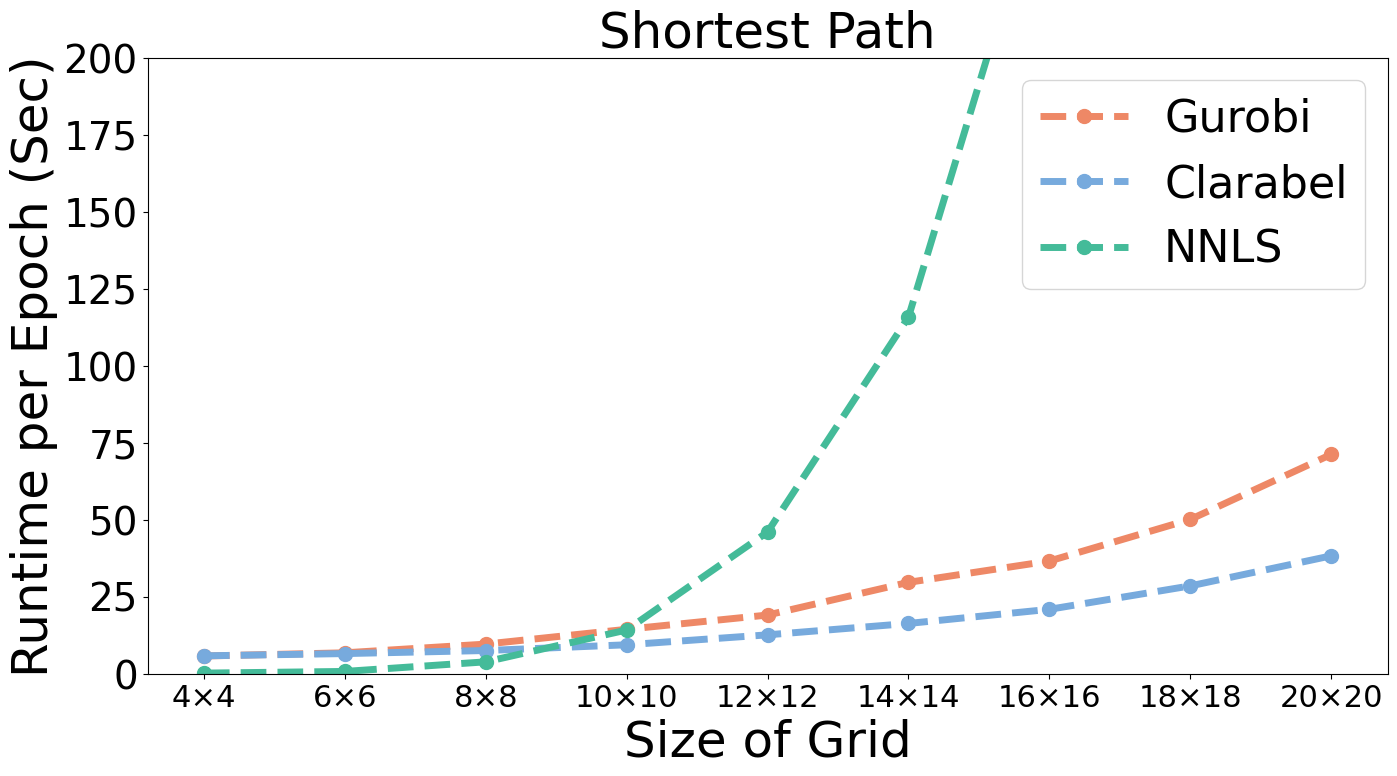

In [9]:
plot(grids, elapsed_grb, elapsed_clb, elapsed_nnls, "Shortest Path")